In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
np.random.seed(42)

In [64]:
historical_data=pd.read_csv('C:\\Users\\karthikeya\\Desktop\\Untitled Folder\\datasets\\historical_data.csv')
historical_data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [65]:
historical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

We see some id columns in the DataFrame, which are generally not useful in prediction tasks. The dataset includes null values which we will deal with at some point within data preprocessing. Most importantly, there is no column in the dataset that represents our target value (the value that we will predict) explicitly. We can deduce it by using the difference between created_at and actual_delivery_time. To do that, we first convert the columns to the DateTime data type. Then, we obtain the time in terms of seconds through _.dt.totalseconds( ). We can use the calculated value as our target in regression.

In [66]:
from datetime import datetime
historical_data['created_at']=pd.to_datetime(historical_data['created_at'])
historical_data["actual_delivery_time"] = pd.to_datetime(historical_data['actual_delivery_time'])
historical_data["actual_total_delivery_duration"] = (historical_data["actual_delivery_time"] - historical_data["created_at"]).dt.total_seconds()
historical_data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0


In [67]:
historical_data['estimated_non_prep_duration'] = historical_data["estimated_store_to_consumer_driving_duration"] + historical_data["estimated_order_place_duration"]
historical_data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,estimated_non_prep_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,1307.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,1136.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,1136.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,735.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1096.0


In [68]:
historical_data["busy_dashers_ratio"] = historical_data["total_busy_dashers"] / historical_data["total_onshift_dashers"]

In [69]:
historical_data[historical_data.busy_dashers_ratio > 1]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,estimated_non_prep_duration,busy_dashers_ratio
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,1136.0,2.000000
7,3.0,2015-02-12 03:03:35,2015-02-12 03:36:20,5477,NaN,1.0,4,4850,4,750,1800,7.0,8.0,7.0,446,626.0,1965.0,1072.0,1.142857
14,1.0,2015-02-12 03:36:46,2015-02-12 04:14:39,2841,italian,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,446,795.0,2273.0,1241.0,1.200000
18,1.0,2015-01-31 04:35:54,2015-01-31 05:47:30,2841,italian,1.0,2,3150,2,1425,1725,4.0,9.0,12.0,446,548.0,4296.0,994.0,2.250000
20,1.0,2015-01-31 23:45:12,2015-02-01 00:14:05,4139,mexican,1.0,5,1285,3,150,400,12.0,13.0,11.0,446,424.0,1733.0,870.0,1.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197411,1.0,2015-02-02 17:50:23,2015-02-02 18:12:57,2956,fast,4.0,2,1297,2,369,639,5.0,6.0,7.0,251,186.0,1354.0,437.0,1.200000
197412,1.0,2015-02-10 23:43:08,2015-02-11 00:47:24,2956,fast,4.0,1,674,1,345,345,10.0,11.0,12.0,251,706.0,3856.0,957.0,1.100000
197418,1.0,2015-01-30 20:50:23,2015-01-30 22:24:38,2956,fast,4.0,2,1528,2,639,729,26.0,29.0,34.0,251,791.0,5655.0,1042.0,1.115385
197422,1.0,2015-01-31 19:48:15,2015-01-31 20:27:39,2956,fast,4.0,7,2445,3,145,585,23.0,24.0,24.0,251,608.0,2364.0,859.0,1.043478


As next, let's look at ids. We have two columns, market_id and store_id that include ids. We can incorporate them by hot-encoding to the DataFrame and dropping the original column. However, we are not sure how many columns would they add to the DataFrame in a hot-encoding case. Let's see.

In [70]:
historical_data["market_id"].nunique()

6

In [71]:
historical_data["store_id"].nunique()

6743

In [72]:
historical_data["order_protocol"].nunique()

7

In [73]:
store_id_unique = historical_data["store_id"].unique().tolist()
store_id_and_category = {store_id: historical_data[historical_data.store_id == store_id].store_primary_category.mode() 
                         for store_id in store_id_unique}

In [74]:
def fill(store_id):
    """Return primary store category from the dictionary"""
    try:
        return store_id_and_category[store_id].values[0]
    except:
        return np.nan

# fill null values
historical_data["nan_free_store_primary_category"] = historical_data.store_id.apply(fill)

In [75]:
historical_data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,estimated_non_prep_duration,busy_dashers_ratio,nan_free_store_primary_category
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,1307.0,0.424242,american
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,1136.0,2.000000,indian
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,1136.0,0.000000,indian
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,735.0,1.000000,indian
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1096.0,1.000000,indian


In [76]:
store_id_and_category[5477]

0     indian
1    mexican
Name: store_primary_category, dtype: object

In [77]:
historical_data[historical_data.store_id == 5477]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,estimated_non_prep_duration,busy_dashers_ratio,nan_free_store_primary_category
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,1136.0,2.000000,indian
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,1136.0,0.000000,indian
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,735.0,1.000000,indian
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1096.0,1.000000,indian
5,3.0,2015-01-28 20:30:38,2015-01-28 21:08:58,5477,NaN,1.0,3,5000,3,1500,1900,2.0,2.0,2.0,446,338.0,2300.0,784.0,1.000000,indian
6,3.0,2015-01-31 02:16:36,2015-01-31 02:43:00,5477,NaN,1.0,2,3900,2,1200,2700,10.0,9.0,9.0,446,638.0,1584.0,1084.0,0.900000,indian
7,3.0,2015-02-12 03:03:35,2015-02-12 03:36:20,5477,NaN,1.0,4,4850,4,750,1800,7.0,8.0,7.0,446,626.0,1965.0,1072.0,1.142857,indian
8,2.0,2015-02-16 00:11:35,2015-02-16 00:38:01,5477,indian,3.0,4,4771,3,820,1604,8.0,6.0,18.0,446,289.0,1586.0,735.0,0.750000,indian
9,3.0,2015-02-18 01:15:45,2015-02-18 02:08:57,5477,NaN,1.0,2,2100,2,700,1200,2.0,2.0,2.0,446,715.0,3192.0,1161.0,1.000000,indian
10,3.0,2015-02-02 19:22:53,2015-02-02 20:09:19,5477,NaN,4.0,4,4300,4,1200,1500,1.0,1.0,1.0,446,453.0,2786.0,899.0,1.000000,indian


In [78]:
# create dummies for order protocol
order_protocol_dummies = pd.get_dummies(historical_data.order_protocol)
order_protocol_dummies = order_protocol_dummies.add_prefix('order_protocol_')
order_protocol_dummies.head()

,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0
0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


In [79]:
# create dummies for market_id
market_id_dummies = pd.get_dummies(historical_data.market_id)
market_id_dummies = market_id_dummies.add_prefix('market_id_')
market_id_dummies.head()

,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0
0,1,0,0,0,0,0
1,0,1,0,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,0,0,1,0,0,0


In [80]:
# create dummies for store primary category
store_primary_category_dummies = pd.get_dummies(historical_data.nan_free_store_primary_category)
store_primary_category_dummies = store_primary_category_dummies.add_prefix('category_')
store_primary_category_dummies.head()

,category_afghan,category_african,category_alcohol,category_alcohol-plus-food,category_american,category_argentine,category_asian,category_barbecue,category_belgian,category_brazilian,category_breakfast,category_british,category_bubble-tea,category_burger,category_burmese,category_cafe,category_cajun,category_caribbean,category_catering,category_cheese,category_chinese,category_chocolate,category_comfort-food,category_convenience-store,category_dessert,category_dim-sum,category_ethiopian,category_european,category_fast,category_filipino,category_french,category_gastropub,category_german,category_gluten-free,category_greek,category_hawaiian,category_indian,category_indonesian,category_irish,category_italian,category_japanese,category_korean,category_kosher,category_latin-american,category_lebanese,category_malaysian,category_mediterranean,category_mexican,category_middle-eastern,category_moroccan,category_nepalese,category_other,category_pakistani,category_pasta,category_persian,category_peruvian,category_pizza,category_russian,category_salad,category_sandwich,category_seafood,category_singaporean,category_smoothie,category_soup,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [81]:
# drop created_at, market_id, store_id, store_primary_category, actual_delivery_time, actual_total_delivery_duration
train_df = historical_data.drop(columns = ["created_at", "market_id", "store_id", "store_primary_category", "actual_delivery_time", 
                                        "nan_free_store_primary_category", "order_protocol"])
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,estimated_non_prep_duration,busy_dashers_ratio
0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,1307.0,0.424242
1,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,1136.0,2.000000
2,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,1136.0,0.000000
3,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,735.0,1.000000
4,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1096.0,1.000000


In [82]:
train_df = pd.concat([train_df, order_protocol_dummies, market_id_dummies, store_primary_category_dummies], axis=1)
# align dtype over dataset
train_df = train_df.astype("float32")
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,estimated_non_prep_duration,busy_dashers_ratio,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0,category_afghan,category_african,category_alcohol,category_alcohol-plus-food,category_american,category_argentine,category_asian,category_barbecue,category_belgian,category_brazilian,category_breakfast,category_british,category_bubble-tea,category_burger,category_burmese,category_cafe,category_cajun,category_caribbean,category_catering,category_cheese,category_chinese,category_chocolate,category_comfort-food,category_convenience-store,category_dessert,category_dim-sum,category_ethiopian,category_european,category_fast,category_filipino,category_french,category_gastropub,category_german,category_gluten-free,category_greek,category_hawaiian,category_indian,category_indonesian,category_irish,category_italian,category_japanese,category_korean,category_kosher,category_latin-american,category_lebanese,category_malaysian,category_mediterranean,category_mexican,category_middle-eastern,category_moroccan,category_nepalese,category_other,category_pakistani,category_pasta,category_persian,category_peruvian,category_pizza,category_russian,category_salad,category_sandwich,category_seafood,category_singaporean,category_smoothie,category_soup,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,21.0,446.0,861.0,3779.0,1307.0,0.424242,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,446.0,690.0,4024.0,1136.0,2.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,0.0,446.0,690.0,1781.0,1136.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,1.0,1.0,2.0,446.0,289.0,3075.0,735.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,6.0,6.0,9.0,446.0,650.0,2390.0,1096.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
train_df.describe()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,estimated_non_prep_duration,busy_dashers_ratio,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0,category_afghan,category_african,category_alcohol,category_alcohol-plus-food,category_american,category_argentine,category_asian,category_barbecue,category_belgian,category_brazilian,category_breakfast,category_british,category_bubble-tea,category_burger,category_burmese,category_cafe,category_cajun,category_caribbean,category_catering,category_cheese,category_chinese,category_chocolate,category_comfort-food,category_convenience-store,category_dessert,category_dim-sum,category_ethiopian,category_european,category_fast,category_filipino,category_french,category_gastropub,category_german,category_gluten-free,category_greek,category_hawaiian,category_indian,category_indonesian,category_irish,category_italian,category_japanese,category_korean,category_kosher,category_latin-american,category_lebanese,category_malaysian,category_mediterranean,category_mexican,category_middle-eastern,category_moroccan,category_nepalese,category_other,category_pakistani,category_pasta,category_persian,category_peruvian,category_pizza,category_russian,category_salad,category_sandwich,category_seafood,category_singaporean,category_smoothie,category_soup,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
count,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,196902.000000,1.974210e+05,196902.000000,1.775900e+05,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.00000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.00000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000
mean,3.196391,2682.242188,2.670791,686.189941,1159.415405,44.808094,41.739746,58.050064,309.313446,545.358765,2.908239e+03,853.935547,NaN,0.277190,0.121827,0.269460,0.098031,0.224335,0.004022,0.000096,0.192663,0.278876,0.118003,0.241095,0.091172,0.073191,0.000588,0.000051,0.009431,0.000005,0.101429,0.000349,0.01360,0.013894,0.000010,0.001580,0.028036,0.000658,0.002700,0.057327,0.004331,0.01129,0.001935,0.001256,0.008403,0.000122,0.048139,0.000005,0.000162,0.001788,0.046002,0.005764,0.000699,0.000106,0.038247,0.001357,0.002923,0.000952,0.000329,0.000299,0.017171,0.007765,0.037690,0.000010,0.000268,0.036834,0.047724,0.009173,0.000263,0.002629,0.000582,0.000507,0.027939,0.087708,0.007501,0.000142,0.001585,0.020134,0.000699,0.003237,0.003277,0.001337,0.089227,0.000091,0.01

In [84]:
train_df["busy_dashers_ratio"].describe()

count    1.775900e+05
mean              NaN
std               NaN
min              -inf
25%      8.269231e-01
50%      9.622642e-01
75%      1.000000e+00
max               inf
Name: busy_dashers_ratio, dtype: float64

In [85]:
# check infinity values with using numpy isfinite() function
np.where(np.any(~np.isfinite(train_df),axis=0) == True)

(array([ 5,  6,  7,  9, 10, 11, 12], dtype=int64),)

In [86]:
# replace inf values with nan to drop all nans
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
# drop all nans
train_df.dropna(inplace=True)
train_df.shape

(177070, 100)

In [87]:
# confirm there is not any remaining nans
train_df.isna().sum().sum()

0

<AxesSubplot:>

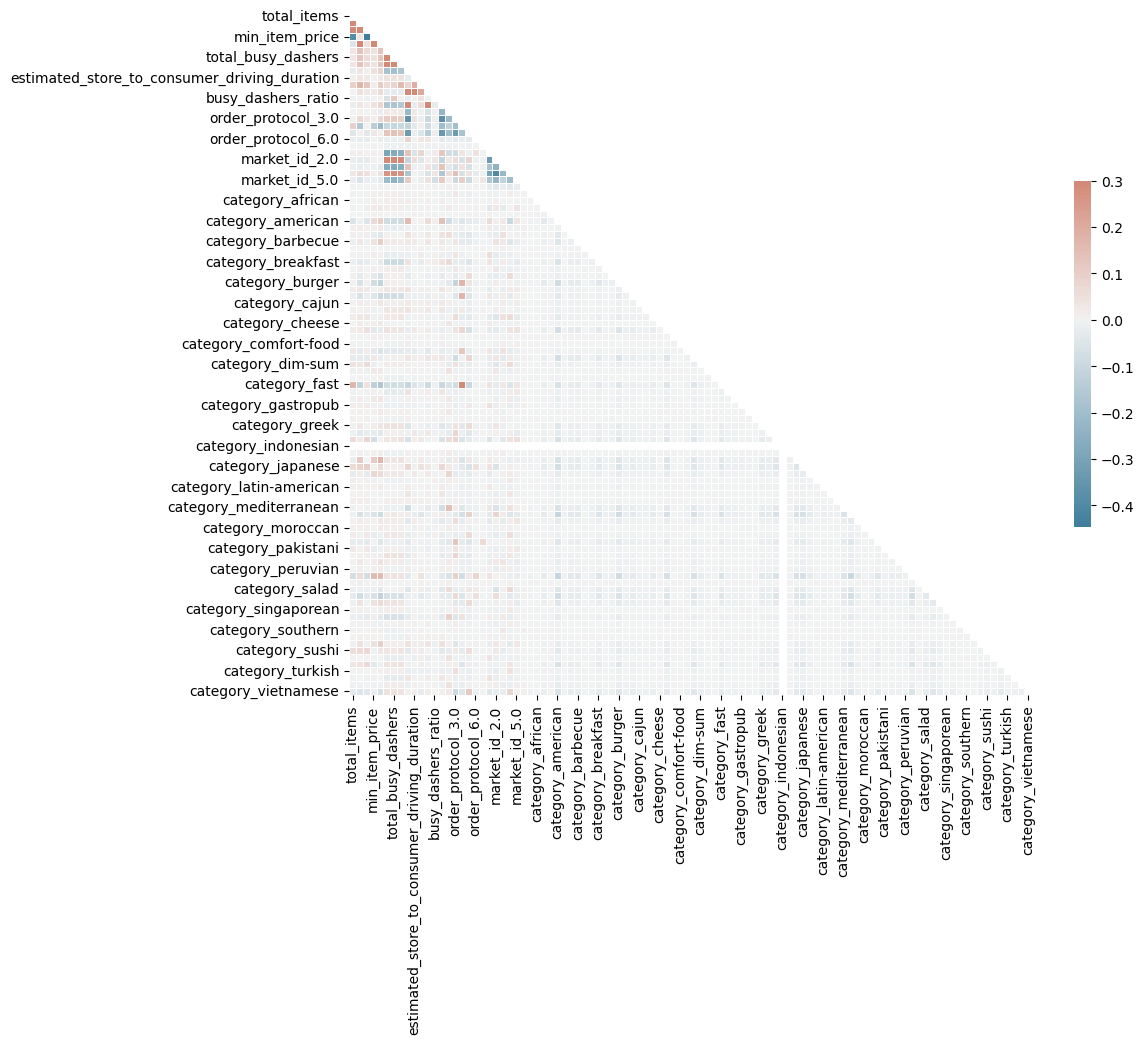

In [88]:
# it could take some time to run this cell since we are calculating correlation matrix in a dimesion of (100x100)
# to have a better visualization, we will take only one triangle 
# because other trangle is only its symmetry (i.e a x b and b x a)

# Generate a mask for the upper triangle
corr = train_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [89]:
train_df['category_indonesian'].describe()

count    177070.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: category_indonesian, dtype: float64

In [90]:
def get_redundant_pairs(df):
    """Get diagonal and lower triangular pairs of correlation matrix"""
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    """Sort correlations in the descending order and return n highest results"""
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_onshift_dashers                         total_busy_dashers             0.941741
                                              total_outstanding_orders       0.934639
total_busy_dashers                            total_outstanding_orders       0.931295
estimated_store_to_consumer_driving_duration  estimated_non_prep_duration    0.923086
estimated_order_place_duration                order_protocol_1.0             0.897645
total_items                                   num_distinct_items             0.758146
subtotal                                      num_distinct_items             0.682890
total_items                                   subtotal                       0.557175
min_item_price                                max_item_price                 0.541241
subtotal                                      max_item_price                 0.507947
order_protocol_4.0                            category_fast                  0.489946
num_distinct_items          

In [91]:
# drop created_at, market_id, store_id, store_primary_category, actual_delivery_time, order_protocol
train_df = historical_data.drop(columns = ["created_at", "market_id", "store_id", "store_primary_category", "actual_delivery_time", 
                                        "nan_free_store_primary_category", "order_protocol"])
# don't concat market id
train_df = pd.concat([train_df, order_protocol_dummies, store_primary_category_dummies], axis=1)
# drop highly correlated features
train_df = train_df.drop(columns=["total_onshift_dashers", "total_busy_dashers",
                                  "category_indonesian", 
                                  "estimated_non_prep_duration"])
# align dtype over dataset
train_df = train_df.astype("float32")
# replace inf values with nan to drop all nans
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,busy_dashers_ratio,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0,category_afghan,category_african,category_alcohol,category_alcohol-plus-food,category_american,category_argentine,category_asian,category_barbecue,category_belgian,category_brazilian,category_breakfast,category_british,category_bubble-tea,category_burger,category_burmese,category_cafe,category_cajun,category_caribbean,category_catering,category_cheese,category_chinese,category_chocolate,category_comfort-food,category_convenience-store,category_dessert,category_dim-sum,category_ethiopian,category_european,category_fast,category_filipino,category_french,category_gastropub,category_german,category_gluten-free,category_greek,category_hawaiian,category_indian,category_irish,category_italian,category_japanese,category_korean,category_kosher,category_latin-american,category_lebanese,category_malaysian,category_mediterranean,category_mexican,category_middle-eastern,category_moroccan,category_nepalese,category_other,category_pakistani,category_pasta,category_persian,category_peruvian,category_pizza,category_russian,category_salad,category_sandwich,category_seafood,category_singaporean,category_smoothie,category_soup,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,0.424242,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,446.0,690.0,4024.0,2.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,0.0,446.0,690.0,1781.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,2.0,446.0,289.0,3075.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,9.0,446.0,650.0,2390.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
train_df.shape

(177070, 90)

In [93]:
# drop created_at, market_id, store_id, store_primary_category, actual_delivery_time, order_protocol
train_df = historical_data.drop(columns = ["created_at", "market_id", "store_id", "store_primary_category", "actual_delivery_time", 
                                        "nan_free_store_primary_category", "order_protocol"])
# don't concat order_protocol_dummies
train_df = pd.concat([train_df, store_primary_category_dummies], axis=1)
train_df = train_df.drop(columns=["total_onshift_dashers", "total_busy_dashers",
                                  "category_indonesian", 
                                  "estimated_non_prep_duration"])
# align dtype over dataset
train_df = train_df.astype("float32")
# replace inf values with nan to drop all nans
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,busy_dashers_ratio,category_afghan,category_african,category_alcohol,category_alcohol-plus-food,category_american,category_argentine,category_asian,category_barbecue,category_belgian,category_brazilian,category_breakfast,category_british,category_bubble-tea,category_burger,category_burmese,category_cafe,category_cajun,category_caribbean,category_catering,category_cheese,category_chinese,category_chocolate,category_comfort-food,category_convenience-store,category_dessert,category_dim-sum,category_ethiopian,category_european,category_fast,category_filipino,category_french,category_gastropub,category_german,category_gluten-free,category_greek,category_hawaiian,category_indian,category_irish,category_italian,category_japanese,category_korean,category_kosher,category_latin-american,category_lebanese,category_malaysian,category_mediterranean,category_mexican,category_middle-eastern,category_moroccan,category_nepalese,category_other,category_pakistani,category_pasta,category_persian,category_peruvian,category_pizza,category_russian,category_salad,category_sandwich,category_seafood,category_singaporean,category_smoothie,category_soup,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,0.424242,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,446.0,690.0,4024.0,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,0.0,446.0,690.0,1781.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,2.0,446.0,289.0,3075.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,9.0,446.0,650.0,2390.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_items                                   num_distinct_items                0.758146
subtotal                                      num_distinct_items                0.682890
total_items                                   subtotal                          0.557175
min_item_price                                max_item_price                    0.541241
subtotal                                      max_item_price                    0.507947
num_distinct_items                            min_item_price                    0.446733
total_items                                   min_item_price                    0.389277
estimated_store_to_consumer_driving_duration  actual_total_delivery_duration    0.188418
subtotal                                      actual_total_delivery_duration    0.172312
total_outstanding_orders                      estimated_order_place_duration    0.171049
total_items                                   category_fast                     0.17

In [95]:
# new features
train_df["percent_distinct_item_of_total"] = train_df["num_distinct_items"] / train_df["total_items"]
train_df["avg_price_per_item"] = train_df["subtotal"] / train_df["total_items"]
train_df.drop(columns=["num_distinct_items", "subtotal"], inplace=True)
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
min_item_price                                avg_price_per_item                0.860580
max_item_price                                avg_price_per_item                0.770382
min_item_price                                max_item_price                    0.541241
total_items                                   percent_distinct_item_of_total    0.445751
                                              min_item_price                    0.389277
                                              avg_price_per_item                0.310759
percent_distinct_item_of_total                avg_price_per_item                0.226711
category_pizza                                avg_price_per_item                0.225510
estimated_store_to_consumer_driving_duration  actual_total_delivery_duration    0.188418
max_item_price                                percent_distinct_item_of_total    0.178021
category_fast                                 avg_price_per_item                0.17

In [96]:
train_df["price_range_of_items"] = train_df["max_item_price"] - train_df["min_item_price"]
train_df.drop(columns=["max_item_price", "min_item_price"], inplace=True)
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_items                                   percent_distinct_item_of_total    0.445751
                                              price_range_of_items              0.333304
                                              avg_price_per_item                0.310759
percent_distinct_item_of_total                avg_price_per_item                0.226711
category_pizza                                avg_price_per_item                0.225510
estimated_store_to_consumer_driving_duration  actual_total_delivery_duration    0.188418
category_fast                                 avg_price_per_item                0.175950
total_outstanding_orders                      estimated_order_place_duration    0.171049
total_items                                   category_fast                     0.170988
category_italian                              avg_price_per_item                0.158193
total_outstanding_orders                      actual_total_delivery_duration    0.15

In [97]:
train_df.shape

(177070, 82)

In [98]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [99]:
def compute_vif(features):
    """Compute VIF score using variance_inflation_factor() function"""
    vif_data = pd.DataFrame()
    vif_data["feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(train_df[features].values, i) for i in range(len(features))]
    return vif_data.sort_values(by=['VIF']).reset_index(drop=True)

In [100]:
# apply VIF computation to all columns
features = train_df.drop(columns=["actual_total_delivery_duration"]).columns.to_list()
vif_data = compute_vif(features)
vif_data

,feature,VIF
0,category_alcohol-plus-food,1.000371
1,category_chocolate,1.000490
2,category_belgian,1.000749
3,category_russian,1.003226
4,category_african,1.003820
...,...,...
76,busy_dashers_ratio,6.369592
77,category_american,7.033601
78,estimated_store_to_consumer_driving_duration,7.210817
79,estimated_order_place_duration,13.472088


In [101]:
# drop with highest vif score until all vif scores are under 20
multicollinearity = True

while multicollinearity:
    highest_vif_feature = vif_data['feature'].values.tolist()[-1]
    print("I will remove", highest_vif_feature)
    features.remove(highest_vif_feature)
    vif_data = compute_vif(features)
    multicollinearity = False if len(vif_data[vif_data.VIF > 20]) == 0 else True

selected_features = vif_data['feature'].values.tolist()
vif_data

I will remove percent_distinct_item_of_total


,feature,VIF
0,category_alcohol-plus-food,1.000222
1,category_chocolate,1.000363
2,category_belgian,1.000451
3,category_russian,1.002016
4,category_gluten-free,1.002363
...,...,...
75,category_american,4.505927
76,avg_price_per_item,5.958953
77,busy_dashers_ratio,6.357883
78,estimated_store_to_consumer_driving_duration,7.192617


In [102]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# selected features are selected in multicollinearity check part
X = train_df[selected_features]
y = train_df["actual_total_delivery_duration"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

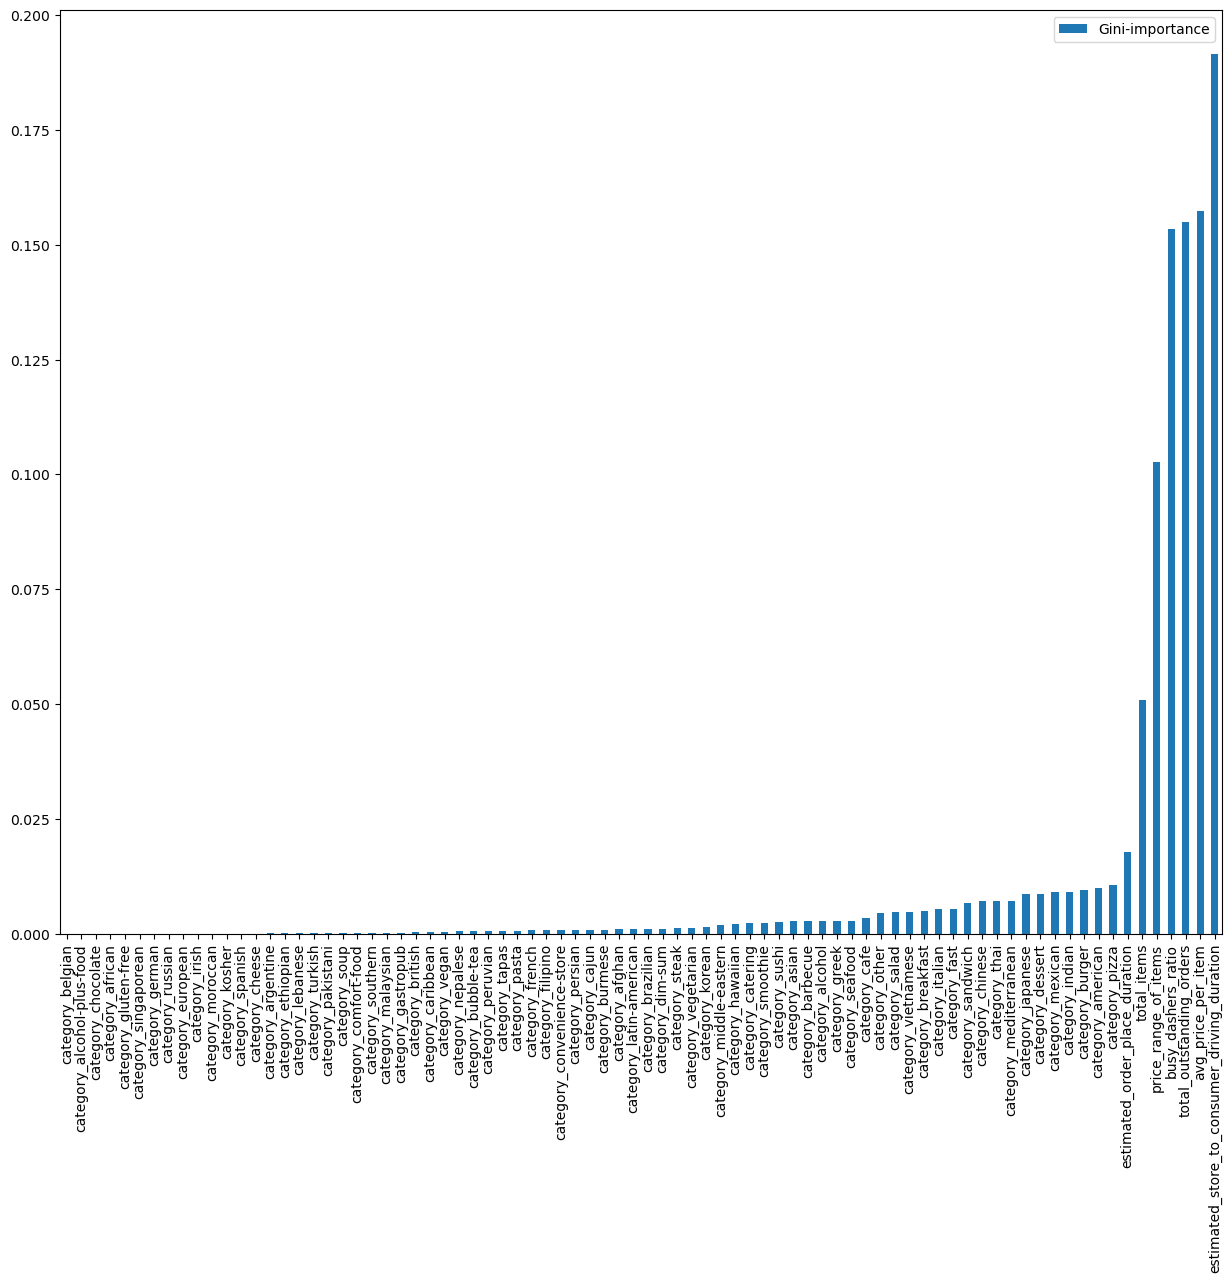

In [103]:
feature_names = [f"feature {i}" for i in range((X.shape[1]))]
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, forest.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90, figsize=(15,12))
plt.show()

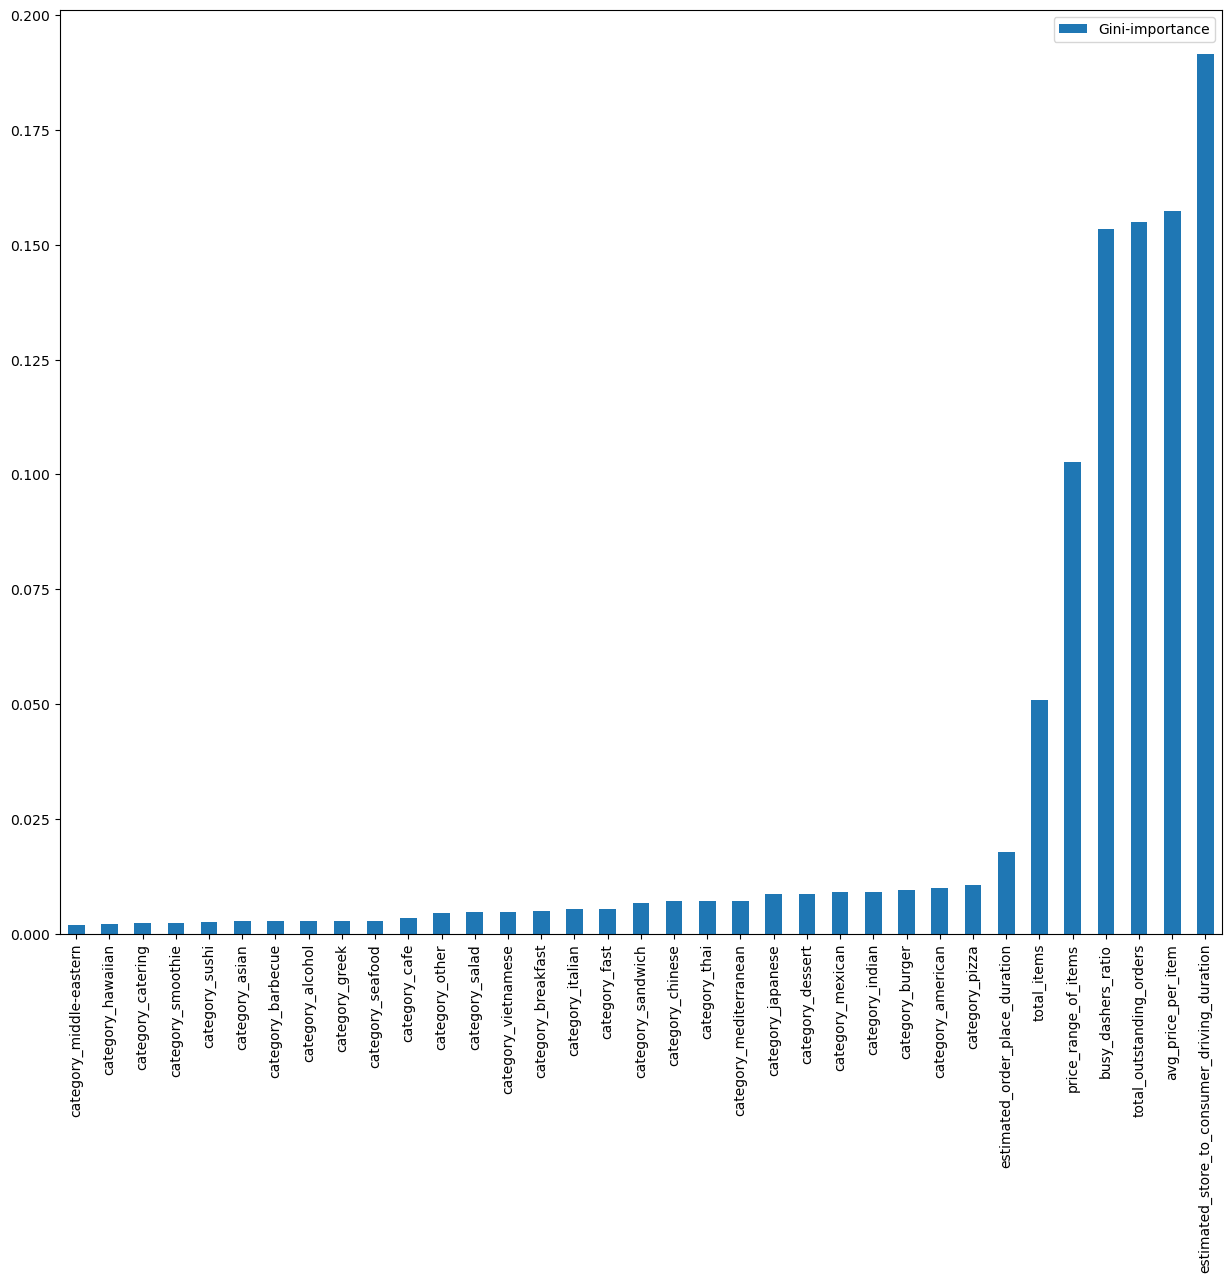

In [104]:
importances.sort_values(by='Gini-importance')[-35:].plot(kind='bar', rot=90, figsize=(15,12))
plt.show()

In [105]:
# we can obtain the column names as next
importances.sort_values(by='Gini-importance')[-35:].index.tolist()


['category_middle-eastern',
 'category_hawaiian',
 'category_catering',
 'category_smoothie',
 'category_sushi',
 'category_asian',
 'category_barbecue',
 'category_alcohol',
 'category_greek',
 'category_seafood',
 'category_cafe',
 'category_other',
 'category_salad',
 'category_vietnamese',
 'category_breakfast',
 'category_italian',
 'category_fast',
 'category_sandwich',
 'category_chinese',
 'category_thai',
 'category_mediterranean',
 'category_japanese',
 'category_dessert',
 'category_mexican',
 'category_indian',
 'category_burger',
 'category_american',
 'category_pizza',
 'estimated_order_place_duration',
 'total_items',
 'price_range_of_items',
 'busy_dashers_ratio',
 'total_outstanding_orders',
 'avg_price_per_item',
 'estimated_store_to_consumer_driving_duration']

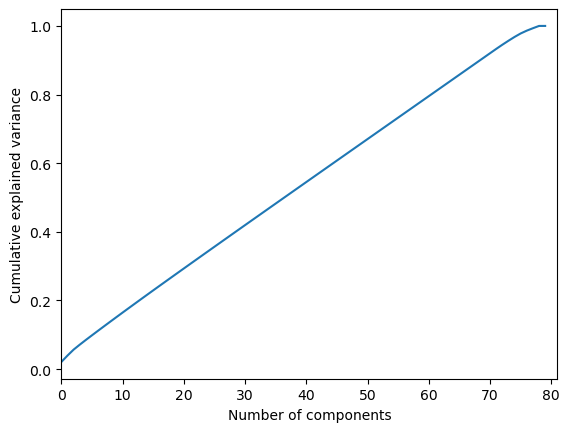

In [106]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_Train=X_train.values
X_Train=np.asarray(X_Train)

# Finding normalised array of X_Train
X_std=StandardScaler().fit_transform(X_Train)
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,81,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [107]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def scale(scaler, X, y):
    """Apply the selected scaler to features and target variables"""
    X_scaler = scaler
    X_scaler.fit(X=X, y=y)
    X_scaled = X_scaler.transform(X)
    y_scaler = scaler
    y_scaler.fit(y.values.reshape(-1, 1))
    y_scaled = y_scaler.transform(y.values.reshape(-1, 1))
    
    return X_scaled, y_scaled, X_scaler, y_scaler

In [108]:
# example to show how to use it
X_scaled, y_scaled, X_scaler, y_scaler = scale(MinMaxScaler(), X, y)

In [109]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
        X_scaled, y_scaled, test_size=0.2, random_state=42)

In [110]:
from sklearn.metrics import mean_squared_error

def rmse_with_inv_transform(scaler, y_test, y_pred_scaled, model_name):
    """Convert the scaled error to actual error"""
    y_predict = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
    # return RMSE with squared False     
    rmse_error = mean_squared_error(y_test, y_predict[:,0], squared=False)
    print("Error = "'{}'.format(rmse_error)+" in " + model_name)
    
    return rmse_error, y_predict

In [111]:
def make_regression(X_train, y_train, X_test, y_test, model, model_name, verbose=True):
    """Apply selected regression model to data and measure error"""
    model.fit(X_train,y_train)
    y_predict=model.predict(X_train)
    train_error = mean_squared_error(y_train, y_predict, squared=False)
    y_predict=model.predict(X_test)
    test_error = mean_squared_error(y_test, y_predict, squared=False)
    if verbose:
        print("Train error = "'{}'.format(train_error)+" in " + model_name)
        print("Test error = "'{}'.format(test_error)+" in " + model_name)
    trained_model = model
    
    return trained_model, y_predict, train_error, test_error

In [112]:
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn import tree
from sklearn import neighbors
from sklearn import linear_model
from xgboost import XGBRegressor

pred_dict = {
    "regression_model": [],
    "feature_set": [],
    "scaler_name": [],
    "RMSE": [],
}


regression_models = {
    "Ridge" : linear_model.Ridge(),
    "DecisionTree" : tree.DecisionTreeRegressor(max_depth=6),
    "RandomForest" : RandomForestRegressor(),
    "GrBoost": GradientBoostingRegressor(),
    "XGBoost": XGBRegressor(),
}


feature_sets = {
    "full dataset": X.columns.to_list(),
    "selected_features_40": importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
    "selected_features_20": importances.sort_values(by='Gini-importance')[-20:].index.tolist(),
    "selected_features_10": importances.sort_values(by='Gini-importance')[-10:].index.tolist(), 

    
}

scalers = {
    "Standard scaler": StandardScaler(),
    "MinMax scaler": MinMaxScaler(),
    "NotScale": None,
}


for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():   
            if scaler_name == "NotScale":
                X = train_df[feature_set]
                y = train_df["actual_total_delivery_duration"]
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                make_regression(X_train, y_train, X_test, y_test, regression_models[model_name], model_name, verbose=True)
            
            else:
                
                X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X[feature_set], y)
                X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
                    X_scaled, y_scaled, test_size=0.2, random_state=42)
                _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=False)
                rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)

            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)

-----scaled with Standard scaler-------- included columns are full dataset

Error = 2053.69873046875 in Ridge
Error = 2057.2476687088733 in DecisionTree
Error = 2048.6751155450784 in RandomForest
Error = 2038.984502661398 in GrBoost
Error = 2036.2498779296875 in XGBoost
-----scaled with MinMax scaler-------- included columns are full dataset

Error = 2053.962890625 in Ridge
Error = 2057.2476685732177 in DecisionTree
Error = 2049.562708243562 in RandomForest
Error = 2038.9545550077148 in GrBoost
Error = 2035.351318359375 in XGBoost
-----scaled with NotScale-------- included columns are full dataset



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=4.42534e-11): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Train error = 1071.4971923828125 in Ridge
Test error = 2053.692626953125 in Ridge
Train error = 1067.7815291116704 in DecisionTree
Test error = 2057.2476684096064 in DecisionTree
Train error = 396.5134229911903 in RandomForest
Test error = 2048.8412132951617 in RandomForest
Train error = 1037.8237617829548 in GrBoost
Test error = 2038.9918415546583 in GrBoost
Train error = 968.2471313476562 in XGBoost
Test error = 2036.43212890625 in XGBoost
-----scaled with Standard scaler-------- included columns are selected_features_40

Error = 2054.00439453125 in Ridge
Error = 2056.5292024696128 in DecisionTree
Error = 2049.2462758130496 in RandomForest
Error = 2038.5808839108277 in GrBoost
Error = 2035.453369140625 in XGBoost
-----scaled with MinMax scaler-------- included columns are selected_features_40

Error = 2054.27734375 in Ridge
Error = 2056.5292023632996 in DecisionTree
Error = 2048.4475233634557 in RandomForest
Error = 2038.5828995489635 in GrBoost
Error = 2034.2847900390625 in XGBoost


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.55922e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Train error = 1067.785563647774 in DecisionTree
Test error = 2056.529202224364 in DecisionTree
Train error = 398.5284853805915 in RandomForest
Test error = 2048.304555394395 in RandomForest
Train error = 1038.1772964108711 in GrBoost
Test error = 2038.5828994193448 in GrBoost
Train error = 965.6858520507812 in XGBoost
Test error = 2035.7642822265625 in XGBoost
-----scaled with Standard scaler-------- included columns are selected_features_20

Error = 2055.36572265625 in Ridge
Error = 2054.610311207463 in DecisionTree
Error = 2048.2331936685014 in RandomForest
Error = 2038.8334940547645 in GrBoost
Error = 2037.6336669921875 in XGBoost
-----scaled with MinMax scaler-------- included columns are selected_features_20

Error = 2055.653076171875 in Ridge
Error = 2054.6103112689557 in DecisionTree
Error = 2046.562555551686 in RandomForest
Error = 2038.8354932825723 in GrBoost
Error = 2036.5164794921875 in XGBoost
-----scaled with NotScale-------- included columns are selected_features_20

Tra

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=4.43858e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Train error = 1069.1350906055598 in DecisionTree
Test error = 2054.610311170708 in DecisionTree
Train error = 400.22292813532084 in RandomForest
Test error = 2048.9637388194433 in RandomForest
Train error = 1038.7474373984592 in GrBoost
Test error = 2038.835493151075 in GrBoost
Train error = 966.1651000976562 in XGBoost
Test error = 2036.249267578125 in XGBoost
-----scaled with Standard scaler-------- included columns are selected_features_10

Error = 2056.568359375 in Ridge
Error = 2054.5971761770547 in DecisionTree
Error = 2051.0243332081236 in RandomForest
Error = 2040.0589319474182 in GrBoost
Error = 2040.27001953125 in XGBoost
-----scaled with MinMax scaler-------- included columns are selected_features_10

Error = 2056.88232421875 in Ridge
Error = 2054.5971762373274 in DecisionTree
Error = 2052.9946697494715 in RandomForest
Error = 2040.0608280600795 in GrBoost
Error = 2039.515625 in XGBoost
-----scaled with NotScale-------- included columns are selected_features_10

Train error 

In [113]:
pred_df = pd.DataFrame(pred_dict)

In [114]:
pred_df

,regression_model,feature_set,scaler_name,RMSE
0,Ridge,full dataset,Standard scaler,2053.698730
1,DecisionTree,full dataset,Standard scaler,2057.247669
2,RandomForest,full dataset,Standard scaler,2048.675116
3,GrBoost,full dataset,Standard scaler,2038.984503
4,XGBoost,full dataset,Standard scaler,2036.249878
5,Ridge,full dataset,MinMax scaler,2053.962891
6,DecisionTree,full dataset,MinMax scaler,2057.247669
7,RandomForest,full dataset,MinMax scaler,2049.562708
8,GrBoost,full dataset,MinMax scaler,2038.954555
9,XGBoost,full dataset,MinMax scaler,2035.351318


<AxesSubplot:>

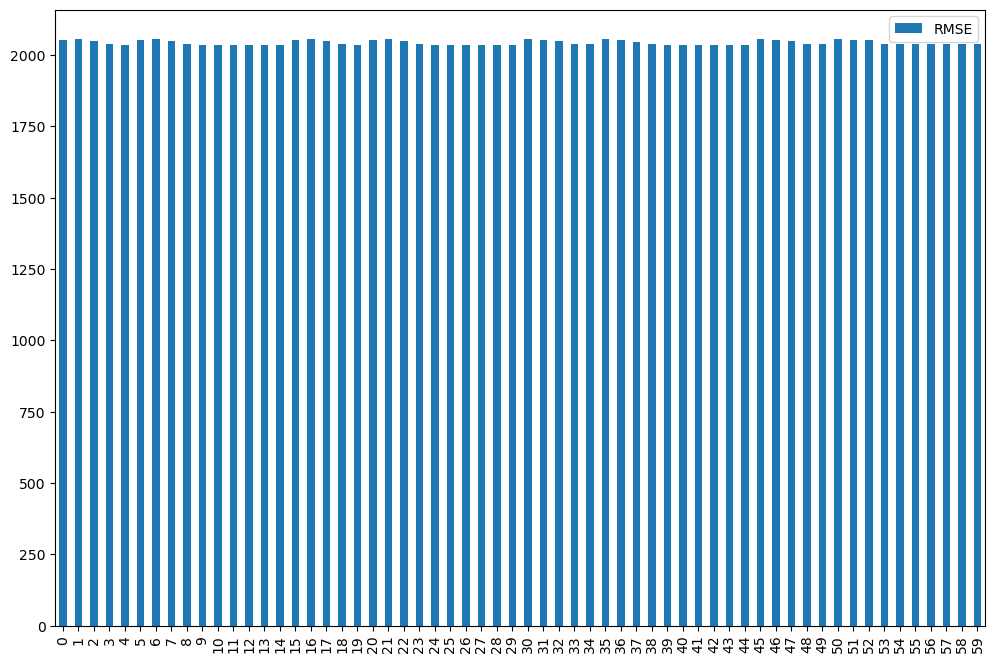

In [115]:
pred_df.plot(kind='bar', figsize=(12,8))

In [116]:
# change the problem a bit
train_df["prep_time"] = train_df["actual_total_delivery_duration"] - train_df["estimated_store_to_consumer_driving_duration"] - train_df["estimated_order_place_duration"]

# not scaling affects the performance, so continue to scale but it doesn't matter much which scaler we used
scalers = {
    "Standard scaler": StandardScaler(),
}

feature_sets = {
    "selected_features_40": importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
}

for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():  
            #drop estimated_store_to_consumer_driving_duration and estimated_order_place_duration
            X = train_df[feature_set].drop(columns=["estimated_store_to_consumer_driving_duration", 
                                           "estimated_order_place_duration"])
            y = train_df["prep_time"]
            
            # to get indices
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            train_indices = X_train.index
            test_indices  = X_test.index
            
            # scale
            X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)
            
            # apply indexing
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
            _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=False)
            rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)
            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)

-----scaled with Standard scaler-------- included columns are selected_features_40

Error = 2055.407470703125 in Ridge
Error = 2045.9600605629953 in DecisionTree
Error = 2049.7179332019628 in RandomForest
Error = 2038.0175198915413 in GrBoost
Error = 2037.8203125 in XGBoost


In [119]:
# not scaling affects the performance, so continue to scale but it doesn't matter much which scaler we used
scalers = {
    "Standard scaler": StandardScaler(),
}

feature_sets = {
    "selected_features_40": importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
}

regression_models = {
    "Ridge" : linear_model.Ridge(),
    "DecisionTree" : tree.DecisionTreeRegressor(max_depth=6),
    "RandomForest" : RandomForestRegressor(),
    "GrBoost": GradientBoostingRegressor(),
    "XGBoost": XGBRegressor(),
}

for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():  
            #drop estimated_store_to_consumer_driving_duration and estimated_order_place_duration
            X = train_df[feature_set].drop(columns=["estimated_store_to_consumer_driving_duration", 
                                           "estimated_order_place_duration"])
            y = train_df["prep_time"]
            
            # to get indices
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            train_indices = X_train.index
            test_indices  = X_test.index
            
            # scale
            X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)
            
            # apply indexing
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
            _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=False)
            rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)
            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)

-----scaled with Standard scaler-------- included columns are selected_features_40

Error = 2055.407470703125 in Ridge
Error = 2045.9600605629953 in DecisionTree
Error = 2048.6595570353775 in RandomForest
Error = 2038.0175198915413 in GrBoost
Error = 2037.8203125 in XGBoost


In [120]:
# choose best perform model and extract the predictions for preparation duration
pred_values_dict = {
    "actual_total_delivery_duration": train_df["actual_total_delivery_duration"][test_indices].values.tolist(), 
    "prep_duration_prediction":y_predict[:,0].tolist(),
    "estimated_store_to_consumer_driving_duration": train_df["estimated_store_to_consumer_driving_duration"][test_indices].values.tolist(),
    "estimated_order_place_duration": train_df["estimated_order_place_duration"][test_indices].values.tolist(),             
}

In [121]:
# convert it to dataframe from dict
values_df = pd.DataFrame.from_dict(pred_values_dict)
values_df

,actual_total_delivery_duration,prep_duration_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration
0,2448.0,1784.876831,380.0,251.0
1,1839.0,1482.157715,747.0,446.0
2,1927.0,2108.508057,543.0,251.0
3,2657.0,1249.367798,445.0,251.0
4,3596.0,1907.054443,691.0,446.0
...,...,...,...,...
35409,9557.0,2719.235840,768.0,446.0
35410,1864.0,2113.291504,324.0,446.0
35411,2674.0,1810.227905,791.0,251.0
35412,2234.0,1889.439941,687.0,251.0


In [122]:
values_df["sum_total_delivery_duration"] = values_df["prep_duration_prediction"] + values_df["estimated_store_to_consumer_driving_duration"] + values_df["estimated_order_place_duration"]
values_df

,actual_total_delivery_duration,prep_duration_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration,sum_total_delivery_duration
0,2448.0,1784.876831,380.0,251.0,2415.876831
1,1839.0,1482.157715,747.0,446.0,2675.157715
2,1927.0,2108.508057,543.0,251.0,2902.508057
3,2657.0,1249.367798,445.0,251.0,1945.367798
4,3596.0,1907.054443,691.0,446.0,3044.054443
...,...,...,...,...,...
35409,9557.0,2719.235840,768.0,446.0,3933.235840
35410,1864.0,2113.291504,324.0,446.0,2883.291504
35411,2674.0,1810.227905,791.0,251.0,2852.227905
35412,2234.0,1889.439941,687.0,251.0,2827.439941


In [123]:
mean_squared_error(values_df["actual_total_delivery_duration"], values_df["sum_total_delivery_duration"], squared=False)

2037.8201791104673

In [124]:
X = values_df[["prep_duration_prediction", "estimated_store_to_consumer_driving_duration", "estimated_order_place_duration"]]
y = values_df["actual_total_delivery_duration"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [126]:
regression_models = {
    "LinearReg" : linear_model.LinearRegression(),
    "Ridge" : linear_model.Ridge(),
    "DecisionTree" : tree.DecisionTreeRegressor(max_depth=6),
    "RandomForest" : RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
}
for model_name in regression_models.keys():
    _, y_predict, _, _= make_regression(
        X_train, y_train, X_test, y_test,regression_models[model_name], model_name, verbose=False)
    print("RMSE of:",model_name, mean_squared_error(y_test,y_predict, squared=False))

RMSE of: LinearReg 1003.0476348895447
RMSE of: Ridge 1003.0476348870704
RMSE of: DecisionTree 1001.1745323290857
RMSE of: RandomForest 1248.0163464249706
RMSE of: XGBoost 1022.7740379439499
